In [1]:
import sys
sys.path.append('/home/npopkov/syndatagenerators/')
import torch
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 
import matplotlib.pyplot as plt

from syndatagenerators.models.ddpm.architectures.UNetPredictor2 import UNet_conditional
from syndatagenerators.models.ddpm.utils.DiffusionUtilities import DiffusionUtilities
from syndatagenerators.models.ddpm.utils.dataprep_utils import getWeekPeriodicEmbedding,getDayPeriodicEmbedding,getYearPeriodicEmbedding,getSummertimes

/tmp/ipykernel_3815812/1448537157.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


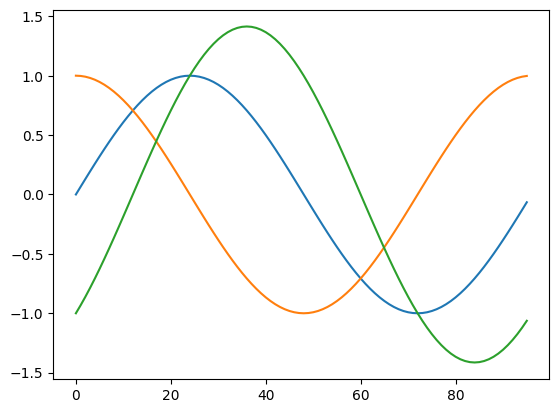

In [2]:
sin = torch.sin(torch.arange(0,2*torch.pi,(2*torch.pi)/96))
cos = torch.cos(torch.arange(0,2*torch.pi,(2*torch.pi)/96))
tan = sin-cos
sample = torch.stack([sin,cos,tan])
sample = sample.repeat([32,1]).view(-1,3,96).to('cuda')
plt.plot(sin)
plt.plot(cos)
plt.plot(tan)

In [3]:
batch_size = 32
n_epochs = 50
lr = 1e-3
n_steps, betaMin, betaMax = 1000, 10**-5, 0.01 


In [4]:
unet = UNet_conditional(n_steps=n_steps,
                        device='cuda',
                        c_in=3,
                        c_out=3,
                        num_classes=None)
ddpm = DiffusionUtilities(network=unet,
                          size=96,
                          betaMin=betaMin,
                          betaMax=betaMax,
                          n_steps=n_steps,
                          device='cuda')
optimizer = torch.optim.AdamW(ddpm.network.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

In [5]:
def testit(i):
    noise = torch.randn_like(sample).float()
    noisy_images = ddpm.addNoise(sample, torch.tensor([i]).repeat([32]), noise)
    noisy_images.shape
    plt.axis('off')
    plt.plot(noisy_images[0,0,:].detach().cpu().numpy())
    plt.plot(noisy_images[0,1,:].detach().cpu().numpy())
    plt.plot(noisy_images[0,2,:].detach().cpu().numpy())
    plt.show()

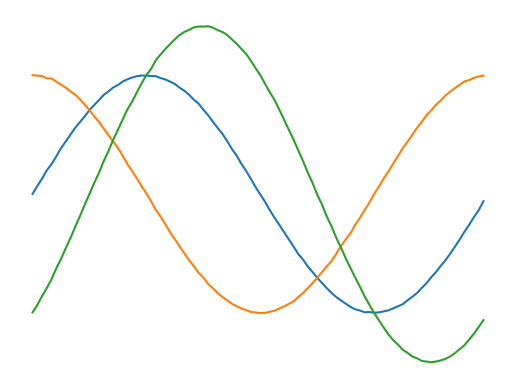

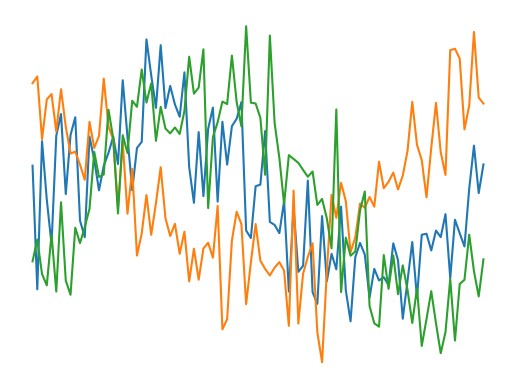

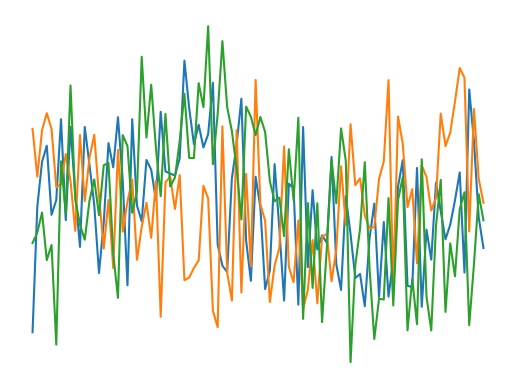

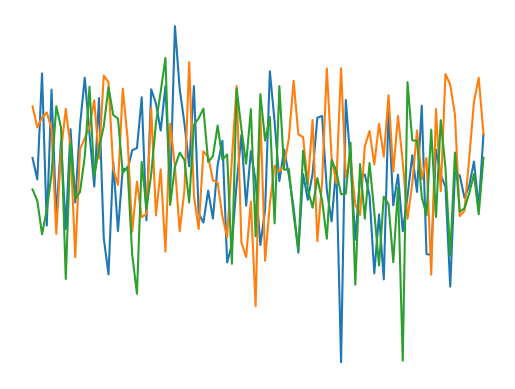

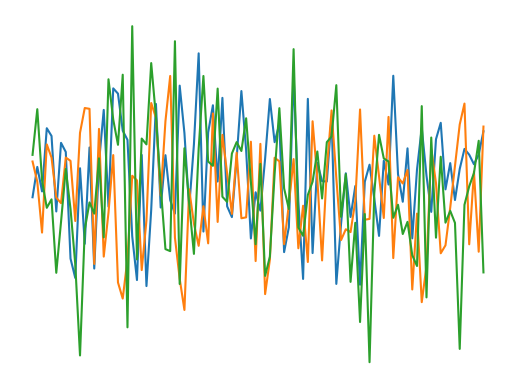

In [6]:
for i in range (0,1000,200):
    testit(i)

In [10]:
def train(ddpm,epochs,sample,criterion,optimizer):
    losses = []
    mean_losses = []
    epoch_loss = 1.0

    for epoch in tqdm(range(epochs), desc=f"Training...", colour="#20f420"):

        noise = torch.randn_like(sample).float().to('cuda')
        
        t = torch.randint(0, ddpm.n_steps, (sample.shape[0], 1)).to('cuda')
        
        noisy_images = ddpm.addNoise(sample, t, noise)
        
        predNoise = ddpm.predictNoise(noisy_images, t.squeeze(),cat=None,cont=None)
        
        loss = criterion(noise, predNoise)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # plt.semilogy(losses)
        # plt.savefig('multiDDPM.png')
        # plt.close()

In [11]:
test = torch.rand([2,96]).repeat([32,1,1])
test.shape

torch.Size([32, 2, 96])

In [12]:
train(ddpm,3000,sample,criterion,optimizer)

Training...:   0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def cond_gen(x,y,cont):
    for t in range(n_steps-1,-1,-1):
        t = torch.tensor([t]).to('cuda')
        x = ddpm.subtractNoise(x=x,t=t,y=y,cont=cont)
    return x

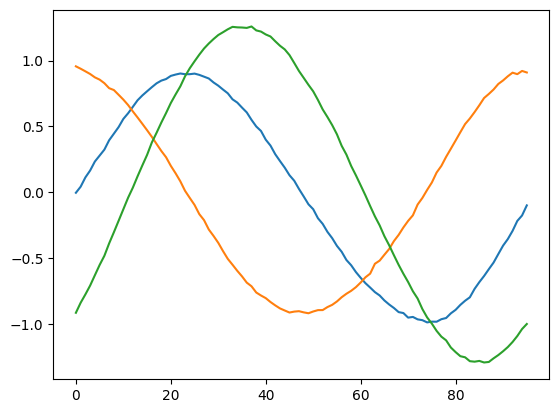

In [ ]:
synthNoise = torch.randn_like(sample).float().to('cuda')
synth = cond_gen(synthNoise,None,None)
plt.plot(synth[0,0,:].detach().cpu().numpy())
plt.plot(synth[0,1,:].detach().cpu().numpy())
plt.plot(synth[0,2,:].detach().cpu().numpy())